In [33]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [35]:
path = r'C:/Users/dskapinakis/Documents/computer_vision_concrete/crack_images'

In [36]:
dataset_train, dataset_test = image_dataset_from_directory(
    directory = path,
    labels = 'inferred', # it takes informations from the subfolders ('Negative', 'Positive')
    label_mode = 'binary', # by default it assigns 0 to first class ('Negative') and 1 ('Positive') to second class alphabetically
    validation_split=0.2,
    seed= 42,
    subset='both',
    batch_size = 64
)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Using 8000 files for validation.


In [37]:
for images, labels in dataset_train.take(1):
    print(images.shape)
    print(labels.shape)

(64, 256, 256, 3)
(64, 1)


* (64, 256, 256, 3) --> 1 batch 64 images/ 256x256 pixels per image/3 rgb
* (64, 1) --> 1 batch 64 images/ label (0 or 1)

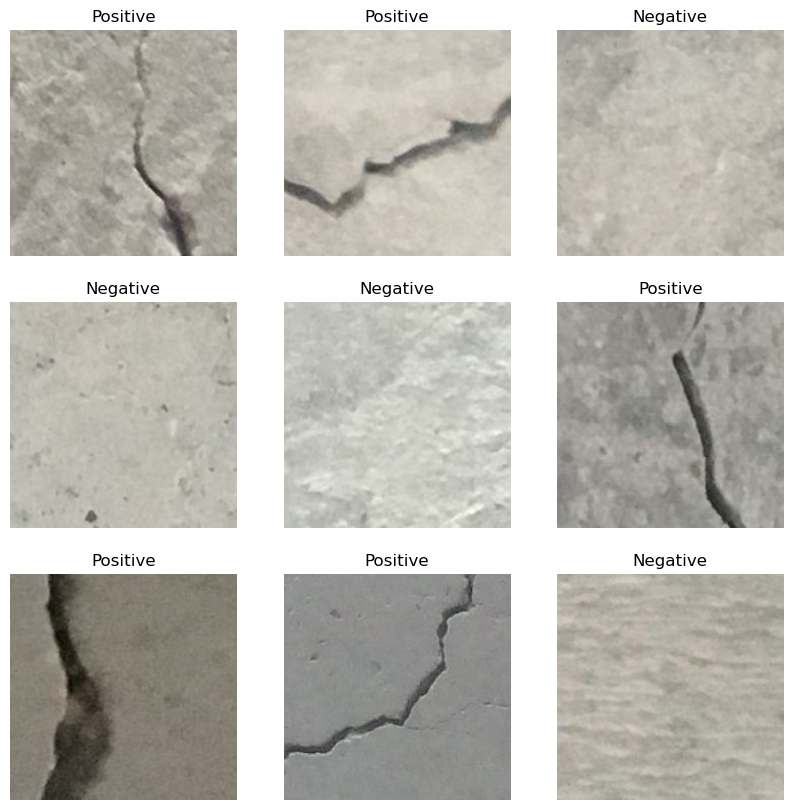

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset_train.class_names[labels[i].numpy()[0].astype(int)])
    plt.axis("off")

In [39]:
#check positive/negative labels
sums_per_batch = []
for images, labels in dataset_train:
    sums_per_batch.append(labels.numpy().astype(int).sum())
print(sum(sums_per_batch))

16028


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = dataset_train
testing_data = dataset_test

dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
#standardize RGB channel values
normalization_layer = Rescaling(1./255)

In [42]:
model = Sequential([
  normalization_layer,
  Conv2D(16, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(16, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(1, activation = 'sigmoid')
])

In [43]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])

Epoch 1/5


500/500 [==============================] - 238s 474ms/step - loss: 0.3239 - accuracy: 0.9266 - val_loss: 0.1023 - val_accuracy: 0.9768
Epoch 2/5
500/500 [==============================] - 226s 452ms/step - loss: 0.0800 - accuracy: 0.9776 - val_loss: 0.0556 - val_accuracy: 0.9837
Epoch 3/5
500/500 [==============================] - 197s 394ms/step - loss: 0.0584 - accuracy: 0.9827 - val_loss: 0.0517 - val_accuracy: 0.9836
Epoch 4/5
500/500 [==============================] - 196s 391ms/step - loss: 0.0405 - accuracy: 0.9886 - val_loss: 0.0466 - val_accuracy: 0.9846
Epoch 5/5
500/500 [==============================] - 204s 409ms/step - loss: 0.0317 - accuracy: 0.9910 - val_loss: 0.0543 - val_accuracy: 0.9825


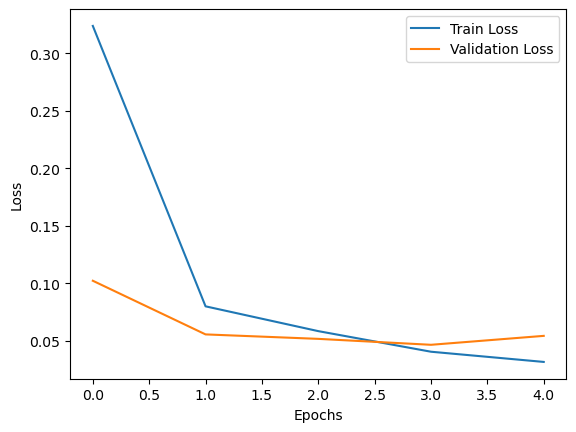

In [44]:
# Train the model
history = model.fit(dataset_train,
                    epochs=5,
                    validation_data = dataset_test,
                    )

# Plot the loss on train vs validate tests
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 52ms/step


C:\Users\dskapinakis\AppData\Local\Temp\ipykernel_26552\182213840.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label = testing_data.class_names[int(labels[i].numpy())]  # Get actual label


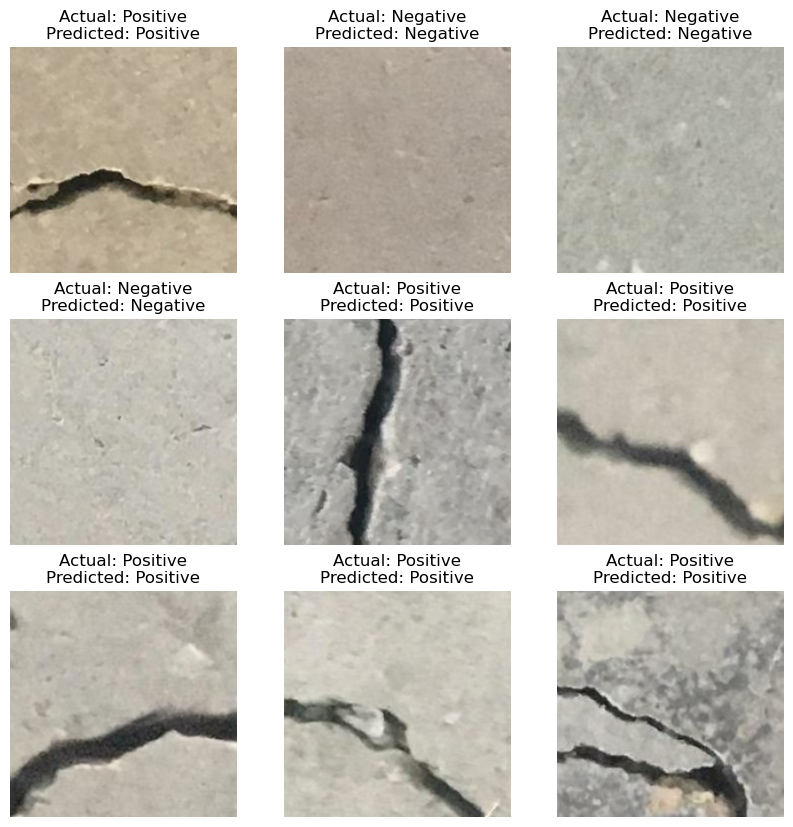

In [45]:
plt.figure(figsize=(10, 10))
for images, labels in dataset_test.take(1):  # Assuming dataset_test is your test dataset
    predictions = model.predict(images)  # Get predictions for the images

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = testing_data.class_names[int(tf.round(predictions[i]))]  # Get predicted label
        actual_label = testing_data.class_names[int(labels[i].numpy())]  # Get actual label
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis("off")

plt.show()


In [46]:
# Collect all predictions and true labels
all_predictions = []
all_true_labels = []

for images, labels in dataset_test:
    predictions = model.predict(images)
    all_predictions.extend(tf.round(predictions).numpy())
    all_true_labels.extend(labels.numpy())

# Convert predictions and true labels to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


2/2 [==============================] - 0s 51ms/step
Confusion Matrix:
[[3941   87]
 [  53 3919]]


In [ ]:
#saving the model 
path_saved_model= r'C:/Users/dskapinakis/Documents/cnn_cracks.keras'
model.save(path_saved_model)